# True Beacon Quant Research Assignment
## - Prachin Patel

### Import Libraries and Setup

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
from itertools import product
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')

### Data Loading and EDA

In [71]:
# Load data
df = pd.read_parquet('data.parquet')
df.index = pd.to_datetime(df.index)  # Ensure time index
df = df.sort_index()

# Basic info
print(f'Head: {df.head()}')
print(f'Columns: {df.columns}')
print(f'Shape: {df.shape}')
print(f'Data date range from: {df.index.min()} to {df.index.max()}')

Head:                      banknifty     nifty  tte
time                                         
2021-01-01 09:15:00   0.286058  0.199729   27
2021-01-01 09:16:00   0.285381  0.200433   27
2021-01-01 09:17:00   0.284233  0.200004   27
2021-01-01 09:18:00   0.286104  0.199860   27
2021-01-01 09:19:00   0.285539  0.198951   27
Columns: Index(['banknifty', 'nifty', 'tte'], dtype='object')
Shape: (690512, 3)
Data date range from: 2021-01-01 09:15:00 to 2022-06-30 15:30:00


In [72]:
df.describe()

,banknifty,nifty,tte
count,689012.000000,688512.000000,690512.000000
mean,0.250156,0.179343,15.671884
std,0.057702,0.046139,8.664597
min,0.152732,0.089355,2.000000
25%,0.205307,0.140375,8.000000
50%,0.243977,0.181210,15.000000
75%,0.295293,0.215635,23.000000
max,0.460619,0.306952,31.000000


In [73]:
# Get unique dates from the index
unique_days = df.index.normalize().unique()

# Count them
num_unique_days = len(unique_days)
print(f"Number of unique days: {num_unique_days}")

Number of unique days: 481


In [74]:
# Get unique time components (without date)
print(f"Earliest time: {df.index.time.min()}")
print(f"Latest time: {df.index.time.max()}")

Earliest time: 00:00:00
Latest time: 23:59:00


In [75]:
# Check missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
banknifty    1500
nifty        2000
tte             0
dtype: int64


In [76]:
# Check duplicates
duplicate_rows = df.reset_index().duplicated().sum()
print(f"Number of completely duplicate rows (including time): {duplicate_rows}")

Number of completely duplicate rows (including time): 0


In [77]:
# Count rows per trading day
rows_per_day = df.groupby(df.index.date).size()

print(rows_per_day.describe())
print(rows_per_day.value_counts().sort_index())

count     481.000000
mean     1435.575884
std        48.407934
min       885.000000
25%      1440.000000
50%      1440.000000
75%      1440.000000
max      1440.000000
dtype: float64
885       2
931       2
1440    477
Name: count, dtype: int64


### Data Preprocessing

In [78]:
# Remove observations outside trading hours (09:15 to 15:30)
df_between = df.between_time('09:15', '15:30')

print(f'Head: {df_between.head()}')
print(f'Columns: {df_between.columns}')
print(f'Shape: {df_between.shape}')
print(f'Data date range from: {df_between.index.min()} to {df_between.index.max()}')

Head:                      banknifty     nifty  tte
time                                         
2021-01-01 09:15:00   0.286058  0.199729   27
2021-01-01 09:16:00   0.285381  0.200433   27
2021-01-01 09:17:00   0.284233  0.200004   27
2021-01-01 09:18:00   0.286104  0.199860   27
2021-01-01 09:19:00   0.285539  0.198951   27
Columns: Index(['banknifty', 'nifty', 'tte'], dtype='object')
Shape: (180856, 3)
Data date range from: 2021-01-01 09:15:00 to 2022-06-30 15:30:00


In [79]:
# Check missing values
print("Missing values per column:")
print(df_between.isnull().sum())

Missing values per column:
banknifty    370
nifty        477
tte            0
dtype: int64


In [80]:
# Count daily NaNs
daily_nans = df_between.isna().groupby(df_between.index.date).sum()
print(daily_nans.head())

# days with any NaN
print("\nDays with NaNs:")
print(daily_nans[daily_nans.sum(axis=1) > 0])

            banknifty  nifty  tte
2021-01-01          0      1    0
2021-01-02          0      1    0
2021-01-03          0      0    0
2021-01-04          1      1    0
2021-01-05          0      1    0

Days with NaNs:
            banknifty  nifty  tte
2021-01-01          0      1    0
2021-01-02          0      1    0
2021-01-04          1      1    0
2021-01-05          0      1    0
2021-01-06          1      1    0
...               ...    ...  ...
2022-06-25          0      2    0
2022-06-26          0      2    0
2022-06-28          3      1    0
2022-06-29          0      2    0
2022-06-30          0      1    0

[409 rows x 3 columns]


In [81]:
# Locate NaN timestamps
nan_locs = {
    col: df_between[df_between[col].isna()].index
    for col in ['banknifty', 'nifty']
}

for col, idx in nan_locs.items():
    print(f"\n--- {col}: {len(idx)} NaNs ---")
    print(idx[:20])     # print first 20 timestamps



--- banknifty: 370 NaNs ---
DatetimeIndex(['2021-01-04 13:25:00', '2021-01-06 14:10:00',
               '2021-01-07 10:02:00', '2021-01-07 12:11:00',
               '2021-01-09 09:21:00', '2021-01-09 09:42:00',
               '2021-01-11 09:30:00', '2021-01-11 12:22:00',
               '2021-01-11 15:11:00', '2021-01-12 10:25:00',
               '2021-01-14 11:59:00', '2021-01-14 12:31:00',
               '2021-01-14 12:53:00', '2021-01-17 09:25:00',
               '2021-01-18 10:09:00', '2021-01-19 11:19:00',
               '2021-01-19 12:34:00', '2021-01-21 14:33:00',
               '2021-01-22 10:18:00', '2021-01-24 12:12:00'],
              dtype='datetime64[us]', name='time', freq=None)

--- nifty: 477 NaNs ---
DatetimeIndex(['2021-01-01 12:39:00', '2021-01-02 12:38:00',
               '2021-01-04 10:33:00', '2021-01-05 12:44:00',
               '2021-01-06 11:58:00', '2021-01-07 12:18:00',
               '2021-01-08 13:25:00', '2021-01-08 13:43:00',
               '2021-01-10 10

In [82]:
# Function to find NaN blocks
def find_nan_blocks(series):
    """Return list of (start_timestamp, end_timestamp, length_in_rows)."""
    s = series.isna()
    blocks = []
    in_block = False
    start = None
    length = 0

    for i in range(len(s)):
        if s.iloc[i] and not in_block:
            # Start of new NaN block
            in_block = True
            start = s.index[i]
            length = 1

        elif s.iloc[i] and in_block:
            # Continue block
            length += 1

        elif not s.iloc[i] and in_block:
            # End block
            end = s.index[i-1]
            blocks.append((start, end, length))
            in_block = False

    # If ended inside a NaN block
    if in_block:
        end = s.index[-1]
        blocks.append((start, end, length))

    return blocks


# Find longest NaN block for each column
for col in ['banknifty', 'nifty']:
    blocks = find_nan_blocks(df_between[col])

    if len(blocks) == 0:
        print(f"No NaN blocks in {col}\n")
        continue

    # sort by block length descending
    blocks_sorted = sorted(blocks, key=lambda x: x[2], reverse=True)
    longest = blocks_sorted[0]

    start_ts, end_ts, length = longest
    minutes = length  # since data is 1-minute freq

    print(f"\n====== Longest NaN block for {col} ======")
    print(f"Start:   {start_ts}")
    print(f"End:     {end_ts}")
    print(f"Length:  {length} rows  ({minutes} minutes)")


====== Longest NaN block for banknifty ======
Start:   2021-01-04 13:25:00
End:     2021-01-04 13:25:00
Length:  1 rows  (1 minutes)

====== Longest NaN block for nifty ======
Start:   2021-01-01 12:39:00
End:     2021-01-01 12:39:00
Length:  1 rows  (1 minutes)


In [83]:
# Imputation function
def impute_intraday_ffill_bfill(df, cols):
    """
    Impute NaNs within each trading day:
    - Forward-fill within each day only
    - If NaNs appear at the start of the day, backward-fill from same day
    - No carryover across different days
    """
    
    df = df.copy()
    
    # group by date (not including time)
    grouped = df.groupby(df.index.date)

    for date, g in grouped:
        for col in cols:
            # Extract the day slice
            day_slice = df.loc[g.index, col]
            
            # First forward-fill within the day
            day_filled = day_slice.ffill()
            
            # Then backward-fill to fix NaNs at the start of the day
            day_filled = day_filled.bfill()
            
            # Write back into original df
            df.loc[g.index, col] = day_filled
    
    return df

cols_to_impute = ['banknifty', 'nifty']
df_imputed = impute_intraday_ffill_bfill(df_between, cols_to_impute)

In [84]:
# Check missing values
print("Missing values per column:")
print(df_imputed.isnull().sum())

Missing values per column:
banknifty    0
nifty        0
tte          0
dtype: int64


In [85]:
# Summary of imputed DataFrame
print(f'Head: {df_imputed.head()}')
print(f'Columns: {df_imputed.columns}')
print(f'Shape: {df_imputed.shape}')
print(f'Data date range from: {df_imputed.index.min()} to {df_imputed.index.max()}')

Head:                      banknifty     nifty  tte
time                                         
2021-01-01 09:15:00   0.286058  0.199729   27
2021-01-01 09:16:00   0.285381  0.200433   27
2021-01-01 09:17:00   0.284233  0.200004   27
2021-01-01 09:18:00   0.286104  0.199860   27
2021-01-01 09:19:00   0.285539  0.198951   27
Columns: Index(['banknifty', 'nifty', 'tte'], dtype='object')
Shape: (180856, 3)
Data date range from: 2021-01-01 09:15:00 to 2022-06-30 15:30:00


### Defining Utility Functions

In [86]:
def calculate_spread(df):
    """Calculate the spread between Bank Nifty and Nifty IV."""
    return df['banknifty'] - df['nifty']

def calculate_pnl(spread_series, tte_series, position_series):
    """
    Calculate P/L based on the formula: P/L = Spread x TTE x 0.7
    Position: 1 for long spread, -1 for short spread, 0 for no position
    """
    spread_change = spread_series.diff()
    pnl = position_series.shift(1) * spread_change * tte_series * 0.7
    return pnl

def calculate_zscore(series, window):
    """Calculate rolling z-score for a given series."""
    rolling_mean = series.shift(1).rolling(window=window).mean()
    rolling_std = series.shift(1).rolling(window=window).std()
    zscore = (series - rolling_mean) / rolling_std
    return zscore

def calculate_performance_metrics(pnl_series):
    """Calculate key performance metrics."""
    cumulative_pnl = pnl_series.cumsum()
    
    # Total P/L
    total_pnl = cumulative_pnl.iloc[-1]
    
    # Sharpe Ratio (annualized)
    # Assuming 375 trading minutes per day, 252 trading days
    returns = pnl_series
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(375 * 252) if returns.std() != 0 else 0
    
    # Maximum Drawdown
    rolling_max = cumulative_pnl.cummax()
    drawdown = cumulative_pnl - rolling_max
    max_drawdown = drawdown.min()
    
    return {
        'Total_PnL': total_pnl,
        'Sharpe_Ratio': sharpe_ratio,
        'Max_Drawdown': max_drawdown,
        'Win_Rate': (pnl_series > 0).sum() / len(pnl_series),
        'Avg_Trade_PnL': pnl_series[pnl_series != 0].mean() if (pnl_series != 0).any() else 0
    }

### Base Model: Z-Score Trading System

In [87]:
def zscore_trading_strategy(df, lookback_window = 1440,
                           entry_threshold = 2.0,
                           exit_threshold = 0.5):
    """
    Base model: Z-score based pairs trading strategy.
    
    Parameters:
    - lookback_window: Rolling window for z-score calculation (default: 1440 = 1 day)
    - entry_threshold: Z-score threshold to enter position
    - exit_threshold: Z-score threshold to exit position
    
    Returns DataFrame with spread, z-score, positions, and P/L
    """
    df = df.copy()
    
    # Calculate spread
    df['spread'] = calculate_spread(df)
    
    # Calculate z-score
    df['zscore'] = calculate_zscore(df['spread'], lookback_window)
    
    # Generate trading signals
    df['position'] = 0
    
    for i in range(lookback_window, len(df)):
        current_zscore = df['zscore'].iloc[i]
        previous_position = df['position'].iloc[i-1]
        
        # Entry signals
        if current_zscore > entry_threshold and previous_position == 0:
            df.loc[df.index[i], 'position'] = -1  # Short spread (sell Bank Nifty IV, buy Nifty IV)
        elif current_zscore < -entry_threshold and previous_position == 0:
            df.loc[df.index[i], 'position'] = 1  # Long spread (buy Bank Nifty IV, sell Nifty IV)
        
        # Exit signals
        elif previous_position == -1 and current_zscore < exit_threshold:
            df.loc[df.index[i], 'position'] = 0
        elif previous_position == 1 and current_zscore > -exit_threshold:
            df.loc[df.index[i], 'position'] = 0
        
        # Hold position
        else:
            df.loc[df.index[i], 'position'] = previous_position
    
    # Calculate P/L
    df['pnl'] = calculate_pnl(df['spread'], df['tte'], df['position'])
    df['cumulative_pnl'] = df['pnl'].cumsum()
    
    return df

### Improved Model: Advanced Pairs Trading Strategy using Kalman Filter Regression

In [88]:
class KalmanFilterRegression:
    """
    Kalman Filter for online estimation of dynamic hedge ratio (beta).
    State: beta (hedge ratio between BankNifty and Nifty)
    Observation: BankNifty_IV = beta * Nifty_IV + noise
    """
    def __init__(self, delta = 1e-4, wt = 1e-3):
        """
        Parameters:
        - delta: Process variance (how much beta can change)
        - wt: Observation variance (measurement noise)
        """
        self.delta = delta
        self.wt = wt
        self.beta = None
        self.P = None  # Covariance
        
    def initialize(self, y, x):
        """Initialize with first observation."""
        self.beta = y / x if x != 0 else 1.0
        self.P = 1.0
        
    def update(self, y, x):
        """
        Update beta estimate with new observation.
        y: BankNifty IV
        x: Nifty IV
        """
        if self.beta is None:
            self.initialize(y, x)
            return self.beta
        
        # Prediction step
        beta_pred = self.beta
        P_pred = self.P + self.delta
        
        # Update step
        if x != 0:
            innovation = y - beta_pred * x
            innovation_var = x**2 * P_pred + self.wt
            
            # Kalman gain
            K = P_pred * x / innovation_var
            
            # Update estimates
            self.beta = beta_pred + K * innovation
            self.P = (1 - K * x) * P_pred
        
        return self.beta

def kalman_filter_strategy(df, 
                           lookback_window = 720,
                           entry_threshold = 2.0,
                           exit_threshold = 0.5,
                           delta = 1e-4):
    """
    Kalman Filter based pairs trading with dynamic hedge ratio.
    Spread = BankNifty_IV - beta * Nifty_IV (where beta is estimated online)
    """
    df = df.copy()
    
    # Initialize Kalman Filter
    kf = KalmanFilterRegression(delta=delta, wt=1e-3)
    
    # Arrays to store results
    betas = []
    spreads = []
    
    # Calculate dynamic beta and spread
    for i in range(len(df)):
        y = df['banknifty'].iloc[i]
        x = df['nifty'].iloc[i]
        
        beta = kf.update(y, x)
        spread = y - beta * x
        
        betas.append(beta)
        spreads.append(spread)
    
    df['beta'] = betas
    df['spread'] = spreads
    
    # Calculate z-score of the spread
    df['zscore'] = calculate_zscore(df['spread'], lookback_window)
    
    # Generate trading signals
    df['position'] = 0
    
    for i in range(lookback_window, len(df)):
        current_zscore = df['zscore'].iloc[i]
        previous_position = df['position'].iloc[i-1]
        
        # Entry signals
        if current_zscore > entry_threshold and previous_position == 0:
            df.loc[df.index[i], 'position'] = -1
        elif current_zscore < -entry_threshold and previous_position == 0:
            df.loc[df.index[i], 'position'] = 1
        
        # Exit signals
        elif previous_position == -1 and current_zscore < exit_threshold:
            df.loc[df.index[i], 'position'] = 0
        elif previous_position == 1 and current_zscore > -exit_threshold:
            df.loc[df.index[i], 'position'] = 0
        
        # Hold position
        else:
            df.loc[df.index[i], 'position'] = previous_position
    
    # Calculate P/L
    df['pnl'] = calculate_pnl(df['spread'], df['tte'], df['position'])
    df['cumulative_pnl'] = df['pnl'].cumsum()
    
    return df

### Comparison & Visualisation

In [89]:
def comprehensive_comparison(strategies_dict):
    """Compare all strategies."""
    results = {}
    
    for name, df in strategies_dict.items():
        metrics = calculate_performance_metrics(df['pnl'])
        results[name] = metrics
    
    comparison = pd.DataFrame(results)
    
    # Add ranking
    comparison.loc['Rank_PnL'] = comparison.loc['Total_PnL'].rank(ascending=False)
    comparison.loc['Rank_Sharpe'] = comparison.loc['Sharpe_Ratio'].rank(ascending=False)
    comparison.loc['Rank_Drawdown'] = comparison.loc['Max_Drawdown'].rank(ascending=False)
    
    return comparison

def plot_comprehensive_results(strategies_dict):
    """Visualize all strategies."""
    fig, axes = plt.subplots(3, 1, figsize=(16, 16))
    
    # 1. Cumulative P/L
    for name, df in strategies_dict.items():
        axes[0].plot(df.index, df['cumulative_pnl'], label=name, alpha=0.7, linewidth=2)
    axes[0].set_title('Cumulative P/L Comparison - All Strategies', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Cumulative P/L')
    axes[0].legend(loc='best')
    axes[0].grid(True, alpha=0.3)
    
    # 2. Spread with Beta (for Kalman-based strategies)
    if 'Kalman_Filter' in strategies_dict:
        df_kf = strategies_dict['Kalman_Filter']
        ax1 = axes[1]
        ax2 = ax1.twinx()
        ax1.plot(df_kf.index, df_kf['spread'], color='blue', alpha=0.5, label='Kalman Spread')
        ax2.plot(df_kf.index, df_kf['beta'], color='red', alpha=0.5, label='Dynamic Beta')
        ax1.set_ylabel('Spread', color='blue')
        ax2.set_ylabel('Beta', color='red')
        ax1.set_title('Kalman Filter: Dynamic Spread and Beta', fontsize=12, fontweight='bold')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        ax1.grid(True, alpha=0.3)
    
    # 3. Rolling Sharpe Ratio (252-period window)
    window = 252 * 60  # ~1 trading month
    for name, df in strategies_dict.items():
        rolling_sharpe = (df['pnl'].rolling(window=window).mean() / 
                         df['pnl'].rolling(window=window).std() * np.sqrt(375 * 252))
        axes[2].plot(df.index, rolling_sharpe, label=name, alpha=0.7, linewidth=1.5)
    axes[2].set_title('Rolling Sharpe Ratio (1-Month Window)', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Sharpe Ratio')
    axes[2].set_xlabel('Date')
    axes[2].legend(loc='best')
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('comprehensive_strategy_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

### Main Execution

ADVANCED VOLATILITY PAIRS TRADING - TRUE BEACON ASSIGNMENT

[1/2] Running Base Model for Comparison...

[2/2] Running Kalman Filter Strategy (Dynamic Hedge Ratio)...

COMPREHENSIVE PERFORMANCE COMPARISON
               Base_Model  Kalman_Filter
Total_PnL      274.248710     558.888960
Sharpe_Ratio    10.144836      20.918571
Max_Drawdown    -5.194455      -1.047051
Win_Rate         0.150501       0.091316
Avg_Trade_PnL    0.005182       0.022902
Rank_PnL         2.000000       1.000000
Rank_Sharpe      2.000000       1.000000
Rank_Drawdown    2.000000       1.000000

TRADING STATISTICS

Base_Model:
  Total Trades: 1589
  Days in Market: 194.76

Kalman_Filter:
  Total Trades: 6771
  Days in Market: 66.74
  Avg Beta: 1.4179
  Beta Std: 0.1563

Generating Comprehensive Visualizations...


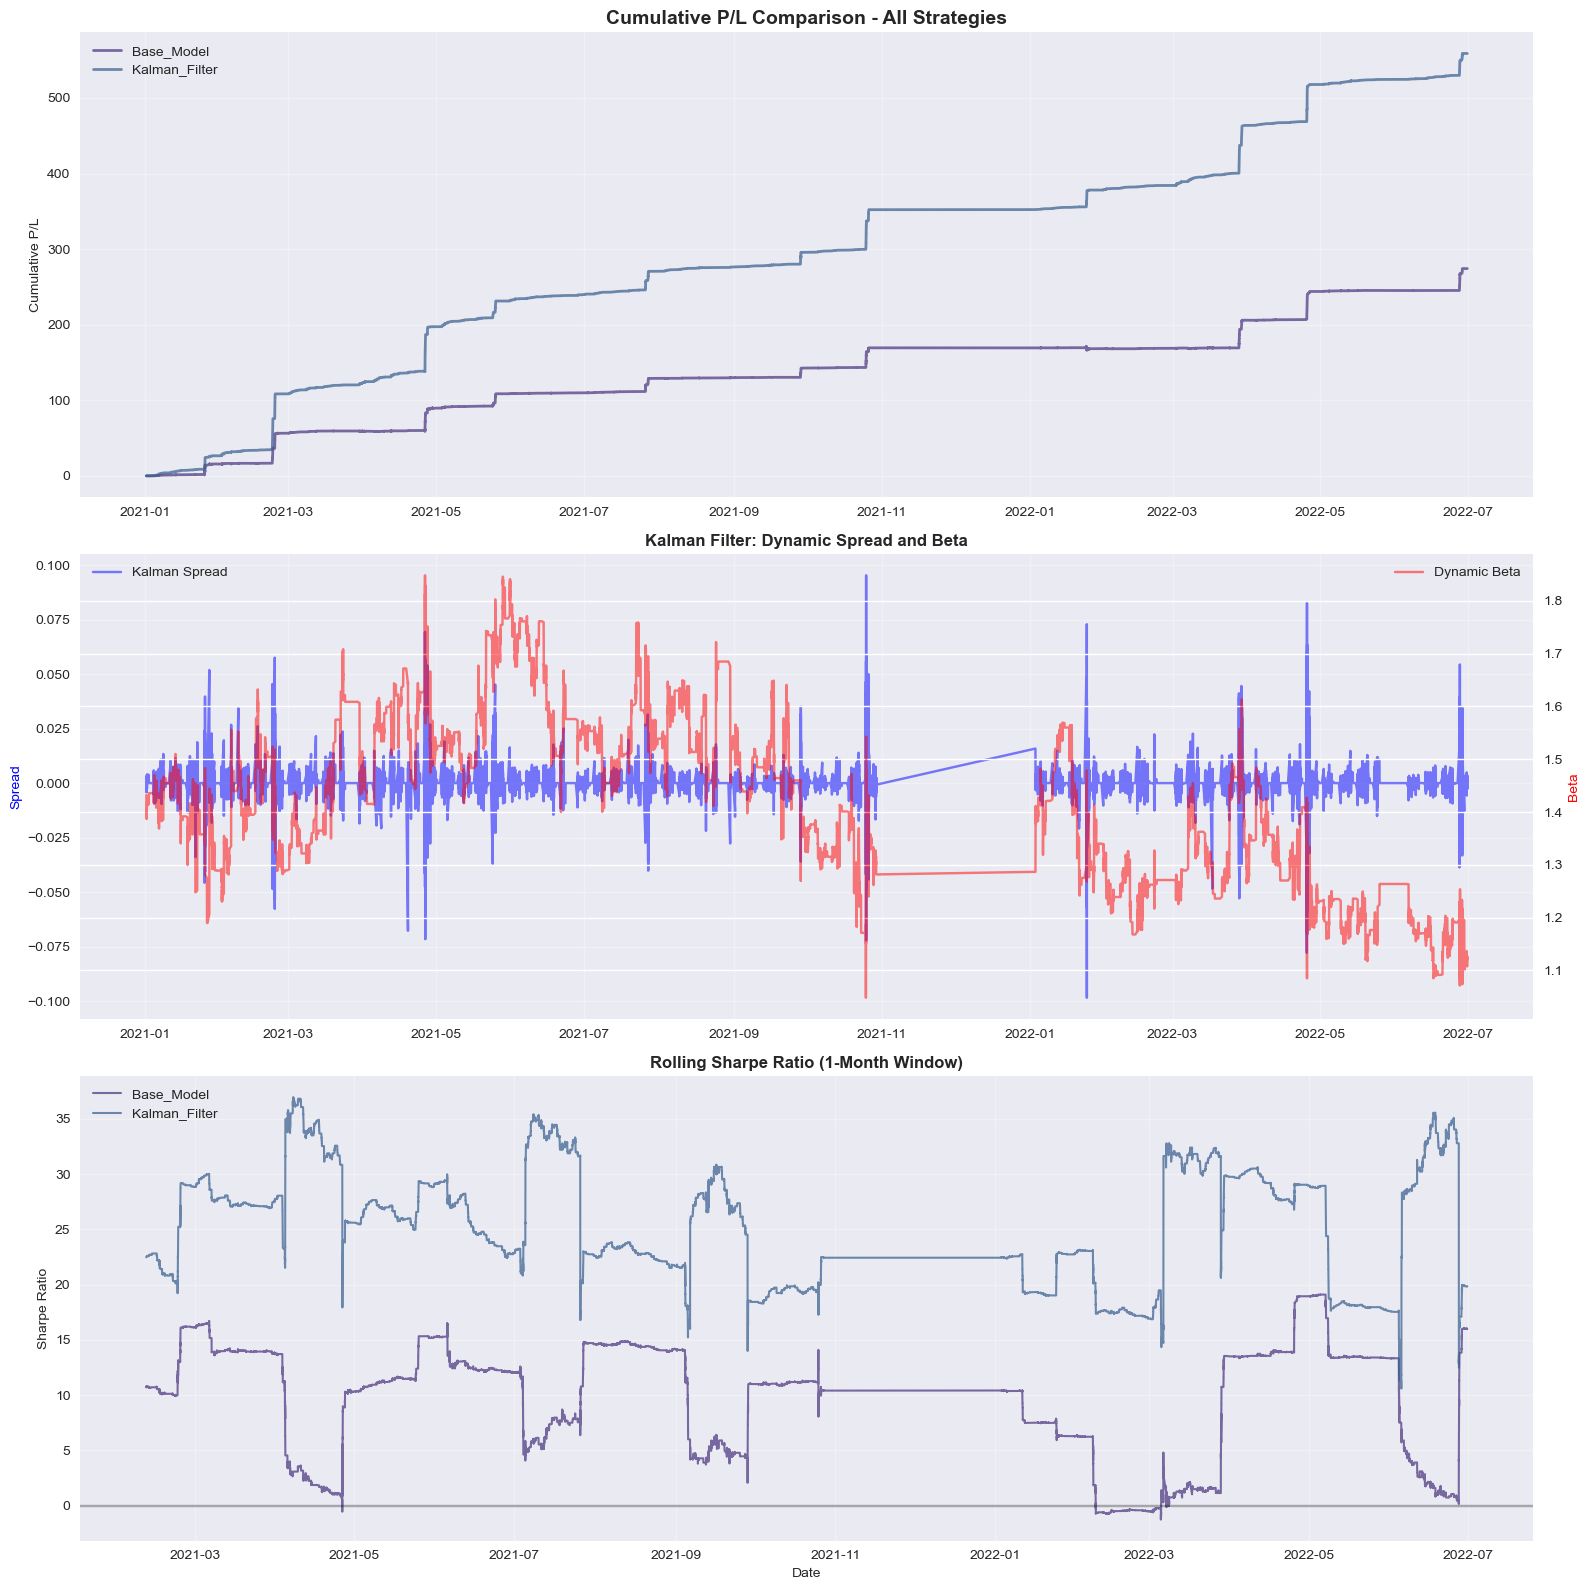


ANALYSIS COMPLETE


In [ ]:
def main(df_imputed):
    """Run strategies and compare."""
    
    print("="*50)
    print("ADVANCED VOLATILITY PAIRS TRADING")
    print("="*50)
    
    strategies = {}

    # Add base model for comparison
    print("\n[1/2] Running Base Model for Comparison...")
    df_base = zscore_trading_strategy(
        df_imputed, 
        lookback_window=1440,
        entry_threshold=2.0,
        exit_threshold=0.5
        )
    strategies['Base_Model'] = df_base
    
    # Run Kalman Filter Strategy
    print("\n[2/2] Running Kalman Filter Strategy (Dynamic Hedge Ratio)...")
    df_kalman = kalman_filter_strategy(
        df_imputed,
        lookback_window=1440,
        entry_threshold=2.0,
        exit_threshold=0.5,
        delta=1e-4
    )
    strategies['Kalman_Filter'] = df_kalman
    
    # Comprehensive comparison
    print("\n" + "="*50)
    print("COMPREHENSIVE PERFORMANCE COMPARISON")
    print("="*50)
    comparison = comprehensive_comparison(strategies)
    print(comparison.to_string())
    
    # Additional statistics
    print("\n" + "="*50)
    print("TRADING STATISTICS")
    print("="*50)
    for name, df in strategies.items():
        total_trades = (df['position'].diff() != 0).sum()
        days_in_market = (df['position'] != 0).sum() / 375
        print(f"\n{name}:")
        print(f"  Total Trades: {total_trades}")
        print(f"  Days in Market: {days_in_market:.2f}")
        if 'beta' in df.columns:
            print(f"  Avg Beta: {df['beta'].mean():.4f}")
            print(f"  Beta Std: {df['beta'].std():.4f}")
    
    # Visualization
    print("\n" + "="*50)
    print("Generating Comprehensive Visualizations...")
    print("="*50)
    plot_comprehensive_results(strategies)
    
    return strategies, comparison

# Run the advanced analysis
if __name__ == "__main__":
    strategies, comparison = main(df_imputed)

### Parameter Grid Search

In [93]:
def create_parameter_grids():
    """
    Create parameter grids for both base and Kalman models.
    These ranges are chosen based on typical pairs trading strategies.
    """
    
    # Base Model (Z-Score) Parameters
    base_param_grid = {
        'lookback_window': [360, 720, 1440, 2880],  # 6h, 12h, 1d, 2d
        'entry_threshold': [1.5, 2.0, 2.5, 3.0],
        'exit_threshold': [0.25, 0.5, 0.75, 1.0]
    }
    
    # Kalman Filter Parameters
    kalman_param_grid = {
        'lookback_window': [360, 720, 1440, 2880],
        'entry_threshold': [1.5, 2.0, 2.5, 3.0],
        'exit_threshold': [0.25, 0.5, 0.75, 1.0],
        'delta': [1e-5, 1e-4, 1e-3, 1e-2]  # Process variance
    }
    
    return base_param_grid, kalman_param_grid

def grid_search_base_model(df, param_grid, optimization_metric='Sharpe_Ratio'):
    """
    Perform grid search for base z-score model.
    
    Parameters:
    - df: Input dataframe
    - param_grid: Dictionary of parameters to search
    - optimization_metric: Metric to optimize ('Total_PnL', 'Sharpe_Ratio', 'Max_Drawdown')
    """
    
    print(f"\n{'='*50}")
    print(f"GRID SEARCH: BASE MODEL (Z-Score Strategy)")
    print(f"Optimization Metric: {optimization_metric}")
    print(f"{'='*50}")
    
    # Generate all parameter combinations
    param_combinations = list(product(
        param_grid['lookback_window'],
        param_grid['entry_threshold'],
        param_grid['exit_threshold']
    ))
    
    print(f"Total combinations to test: {len(param_combinations)}")
    
    results = []
    
    # Test each combination
    for lookback, entry_th, exit_th in tqdm(param_combinations, desc="Testing Base Model"):
        try:
            # Run strategy with current parameters
            df_result = zscore_trading_strategy(
                df,
                lookback_window=lookback,
                entry_threshold=entry_th,
                exit_threshold=exit_th
            )
            
            # Calculate metrics
            metrics = calculate_performance_metrics(df_result['pnl'])
            
            # Store results
            results.append({
                'lookback_window': lookback,
                'entry_threshold': entry_th,
                'exit_threshold': exit_th,
                'Total_PnL': metrics['Total_PnL'],
                'Sharpe_Ratio': metrics['Sharpe_Ratio'],
                'Max_Drawdown': metrics['Max_Drawdown'],
                'Win_Rate': metrics['Win_Rate'],
                'Avg_Trade_PnL': metrics['Avg_Trade_PnL']
            })
            
        except Exception as e:
            print(f"Error with params ({lookback}, {entry_th}, {exit_th}): {e}")
            continue
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Find best parameters
    if optimization_metric == 'Max_Drawdown':
        # For drawdown, higher (less negative) is better
        best_idx = results_df[optimization_metric].idxmax()
    else:
        # For PnL and Sharpe, higher is better
        best_idx = results_df[optimization_metric].idxmax()
    
    best_params = results_df.loc[best_idx].to_dict()
    
    print(f"\n{'='*50}")
    print(f"BEST PARAMETERS (Base Model):")
    print(f"{'='*50}")
    print(f"  Lookback Window: {int(best_params['lookback_window'])} minutes")
    print(f"  Entry Threshold: {best_params['entry_threshold']:.2f}")
    print(f"  Exit Threshold: {best_params['exit_threshold']:.2f}")
    print(f"\n  Performance Metrics:")
    print(f"    Total P/L: {best_params['Total_PnL']:.2f}")
    print(f"    Sharpe Ratio: {best_params['Sharpe_Ratio']:.2f}")
    print(f"    Max Drawdown: {best_params['Max_Drawdown']:.2f}")
    print(f"    Win Rate: {best_params['Win_Rate']:.4f}")
    
    return best_params, results_df

def grid_search_kalman_model(df, param_grid, optimization_metric='Sharpe_Ratio'):
    """
    Perform grid search for Kalman filter model.
    
    Parameters:
    - df: Input dataframe
    - param_grid: Dictionary of parameters to search
    - optimization_metric: Metric to optimize
    """
    
    print(f"\n{'='*50}")
    print(f"GRID SEARCH: KALMAN FILTER MODEL")
    print(f"Optimization Metric: {optimization_metric}")
    print(f"{'='*50}")
    
    # Generate all parameter combinations
    param_combinations = list(product(
        param_grid['lookback_window'],
        param_grid['entry_threshold'],
        param_grid['exit_threshold'],
        param_grid['delta']
    ))
    
    print(f"Total combinations to test: {len(param_combinations)}")
    
    results = []
    
    # Test each combination
    for lookback, entry_th, exit_th, delta in tqdm(param_combinations, desc="Testing Kalman Model"):
        try:
            # Run strategy with current parameters
            df_result = kalman_filter_strategy(
                df,
                lookback_window=lookback,
                entry_threshold=entry_th,
                exit_threshold=exit_th,
                delta=delta
            )
            
            # Calculate metrics
            metrics = calculate_performance_metrics(df_result['pnl'])
            
            # Store results
            results.append({
                'lookback_window': lookback,
                'entry_threshold': entry_th,
                'exit_threshold': exit_th,
                'delta': delta,
                'Total_PnL': metrics['Total_PnL'],
                'Sharpe_Ratio': metrics['Sharpe_Ratio'],
                'Max_Drawdown': metrics['Max_Drawdown'],
                'Win_Rate': metrics['Win_Rate'],
                'Avg_Trade_PnL': metrics['Avg_Trade_PnL']
            })
            
        except Exception as e:
            print(f"Error with params ({lookback}, {entry_th}, {exit_th}, {delta}): {e}")
            continue
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Find best parameters
    if optimization_metric == 'Max_Drawdown':
        best_idx = results_df[optimization_metric].idxmax()
    else:
        best_idx = results_df[optimization_metric].idxmax()
    
    best_params = results_df.loc[best_idx].to_dict()
    
    print(f"\n{'='*50}")
    print(f"BEST PARAMETERS (Kalman Filter):")
    print(f"{'='*50}")
    print(f"  Lookback Window: {int(best_params['lookback_window'])} minutes")
    print(f"  Entry Threshold: {best_params['entry_threshold']:.2f}")
    print(f"  Exit Threshold: {best_params['exit_threshold']:.2f}")
    print(f"  Delta (Process Variance): {best_params['delta']:.2e}")
    print(f"\n  Performance Metrics:")
    print(f"    Total P/L: {best_params['Total_PnL']:.2f}")
    print(f"    Sharpe Ratio: {best_params['Sharpe_Ratio']:.2f}")
    print(f"    Max Drawdown: {best_params['Max_Drawdown']:.2f}")
    print(f"    Win Rate: {best_params['Win_Rate']:.4f}")
    
    return best_params, results_df

def plot_grid_search_results(base_results, kalman_results):
    """
    Visualize grid search results for both models.
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Base Model Visualizations
    # 1. Sharpe vs Entry Threshold
    base_grouped = base_results.groupby('entry_threshold')['Sharpe_Ratio'].mean()
    axes[0, 0].bar(base_grouped.index, base_grouped.values, color='steelblue', alpha=0.7)
    axes[0, 0].set_title('Base Model: Sharpe Ratio vs Entry Threshold', fontweight='bold')
    axes[0, 0].set_xlabel('Entry Threshold')
    axes[0, 0].set_ylabel('Avg Sharpe Ratio')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. PnL vs Lookback Window
    base_grouped = base_results.groupby('lookback_window')['Total_PnL'].mean()
    axes[0, 1].plot(base_grouped.index, base_grouped.values, marker='o', 
                     linewidth=2, markersize=8, color='steelblue')
    axes[0, 1].set_title('Base Model: P/L vs Lookback Window', fontweight='bold')
    axes[0, 1].set_xlabel('Lookback Window (minutes)')
    axes[0, 1].set_ylabel('Avg Total P/L')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Heatmap: Entry vs Exit Threshold
    pivot = base_results.pivot_table(
        values='Sharpe_Ratio',
        index='entry_threshold',
        columns='exit_threshold',
        aggfunc='mean'
    )
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn', ax=axes[0, 2], cbar_kws={'label': 'Sharpe Ratio'})
    axes[0, 2].set_title('Base Model: Entry vs Exit Threshold', fontweight='bold')
    
    # Kalman Model Visualizations
    # 4. Sharpe vs Delta
    kalman_grouped = kalman_results.groupby('delta')['Sharpe_Ratio'].mean()
    axes[1, 0].bar(range(len(kalman_grouped)), kalman_grouped.values, 
                    color='coral', alpha=0.7)
    axes[1, 0].set_xticks(range(len(kalman_grouped)))
    axes[1, 0].set_xticklabels([f'{d:.0e}' for d in kalman_grouped.index], rotation=45)
    axes[1, 0].set_title('Kalman Model: Sharpe Ratio vs Delta', fontweight='bold')
    axes[1, 0].set_xlabel('Delta (Process Variance)')
    axes[1, 0].set_ylabel('Avg Sharpe Ratio')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. PnL vs Lookback Window
    kalman_grouped = kalman_results.groupby('lookback_window')['Total_PnL'].mean()
    axes[1, 1].plot(kalman_grouped.index, kalman_grouped.values, marker='s', 
                     linewidth=2, markersize=8, color='coral')
    axes[1, 1].set_title('Kalman Model: P/L vs Lookback Window', fontweight='bold')
    axes[1, 1].set_xlabel('Lookback Window (minutes)')
    axes[1, 1].set_ylabel('Avg Total P/L')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Heatmap: Entry vs Exit Threshold
    pivot = kalman_results.pivot_table(
        values='Sharpe_Ratio',
        index='entry_threshold',
        columns='exit_threshold',
        aggfunc='mean'
    )
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn', ax=axes[1, 2], cbar_kws={'label': 'Sharpe Ratio'})
    axes[1, 2].set_title('Kalman Model: Entry vs Exit Threshold', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('grid_search_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def compare_optimized_models(df, base_best_params, kalman_best_params):
    """
    Run both models with optimized parameters and compare performance.
    """
    print(f"\n{'='*80}")
    print(f"FINAL COMPARISON: OPTIMIZED MODELS")
    print(f"{'='*80}")
    
    # Run optimized base model
    print("\nRunning Optimized Base Model...")
    df_base_opt = zscore_trading_strategy(
        df,
        lookback_window=int(base_best_params['lookback_window']),
        entry_threshold=base_best_params['entry_threshold'],
        exit_threshold=base_best_params['exit_threshold']
    )
    
    # Run optimized Kalman model
    print("Running Optimized Kalman Model...")
    df_kalman_opt = kalman_filter_strategy(
        df,
        lookback_window=int(kalman_best_params['lookback_window']),
        entry_threshold=kalman_best_params['entry_threshold'],
        exit_threshold=kalman_best_params['exit_threshold'],
        delta=kalman_best_params['delta']
    )
    
    # Calculate metrics
    strategies = {
        'Base_Model_Optimized': df_base_opt,
        'Kalman_Filter_Optimized': df_kalman_opt
    }
    
    comparison = comprehensive_comparison(strategies)
    
    print(f"\n{'='*80}")
    print("PERFORMANCE COMPARISON - OPTIMIZED MODELS")
    print(f"{'='*80}")
    print(comparison.to_string())
    
    # Calculate improvement
    print(f"\n{'='*80}")
    print("IMPROVEMENT ANALYSIS")
    print(f"{'='*80}")
    
    improvement_pnl = ((kalman_best_params['Total_PnL'] - base_best_params['Total_PnL']) / 
                       abs(base_best_params['Total_PnL']) * 100)
    improvement_sharpe = ((kalman_best_params['Sharpe_Ratio'] - base_best_params['Sharpe_Ratio']) / 
                          abs(base_best_params['Sharpe_Ratio']) * 100)
    improvement_dd = ((kalman_best_params['Max_Drawdown'] - base_best_params['Max_Drawdown']) / 
                      abs(base_best_params['Max_Drawdown']) * 100)
    
    print(f"\nKalman vs Base Model:")
    print(f"  P/L Improvement: {improvement_pnl:+.2f}%")
    print(f"  Sharpe Improvement: {improvement_sharpe:+.2f}%")
    print(f"  Drawdown Improvement: {improvement_dd:+.2f}%")
    
    # Plot comparison
    plot_optimized_comparison(strategies)
    
    return strategies, comparison


def plot_optimized_comparison(strategies_dict):
    """
    Visualize optimized strategies comparison.
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Cumulative P/L
    for name, df in strategies_dict.items():
        axes[0, 0].plot(df.index, df['cumulative_pnl'], label=name, linewidth=2.5, alpha=0.8)
    axes[0, 0].set_title('Cumulative P/L - Optimized Models', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Cumulative P/L')
    axes[0, 0].legend(loc='best', fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Drawdown
    for name, df in strategies_dict.items():
        rolling_max = df['cumulative_pnl'].cummax()
        drawdown = df['cumulative_pnl'] - rolling_max
        axes[0, 1].fill_between(df.index, drawdown, 0, alpha=0.4, label=name)
    axes[0, 1].set_title('Drawdown Comparison', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Drawdown')
    axes[0, 1].legend(loc='best', fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Rolling Sharpe
    window = 252 * 60
    for name, df in strategies_dict.items():
        rolling_sharpe = (df['pnl'].rolling(window=window).mean() / 
                         df['pnl'].rolling(window=window).std() * np.sqrt(375 * 252))
        axes[1, 0].plot(df.index, rolling_sharpe, label=name, linewidth=2, alpha=0.8)
    axes[1, 0].set_title('Rolling Sharpe Ratio (1-Month)', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Sharpe Ratio')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].legend(loc='best', fontsize=11)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Distribution of Returns
    for name, df in strategies_dict.items():
        axes[1, 1].hist(df['pnl'][df['pnl'] != 0], bins=50, alpha=0.5, label=name, density=True)
    axes[1, 1].set_title('P/L Distribution', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('P/L')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].legend(loc='best', fontsize=11)
    axes[1, 1].axvline(x=0, color='black', linestyle='--', alpha=0.3)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('optimized_models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

GRID SEARCH PARAMETER OPTIMIZATION

GRID SEARCH: BASE MODEL (Z-Score Strategy)
Optimization Metric: Sharpe_Ratio
Total combinations to test: 64


Testing Base Model: 100%|██████████| 64/64 [16:00<00:00, 15.01s/it]



BEST PARAMETERS (Base Model):
  Lookback Window: 360 minutes
  Entry Threshold: 1.50
  Exit Threshold: 1.00

  Performance Metrics:
    Total P/L: 362.37
    Sharpe Ratio: 15.76
    Max Drawdown: -2.01
    Win Rate: 0.1253

GRID SEARCH: KALMAN FILTER MODEL
Optimization Metric: Sharpe_Ratio
Total combinations to test: 256


Testing Kalman Model: 100%|██████████| 256/256 [3:14:08<00:00, 45.50s/it]    



BEST PARAMETERS (Kalman Filter):
  Lookback Window: 1440 minutes
  Entry Threshold: 1.50
  Exit Threshold: 0.25
  Delta (Process Variance): 1.00e-02

  Performance Metrics:
    Total P/L: 622.03
    Sharpe Ratio: 31.88
    Max Drawdown: -0.72
    Win Rate: 0.1215

Generating Grid Search Visualizations...


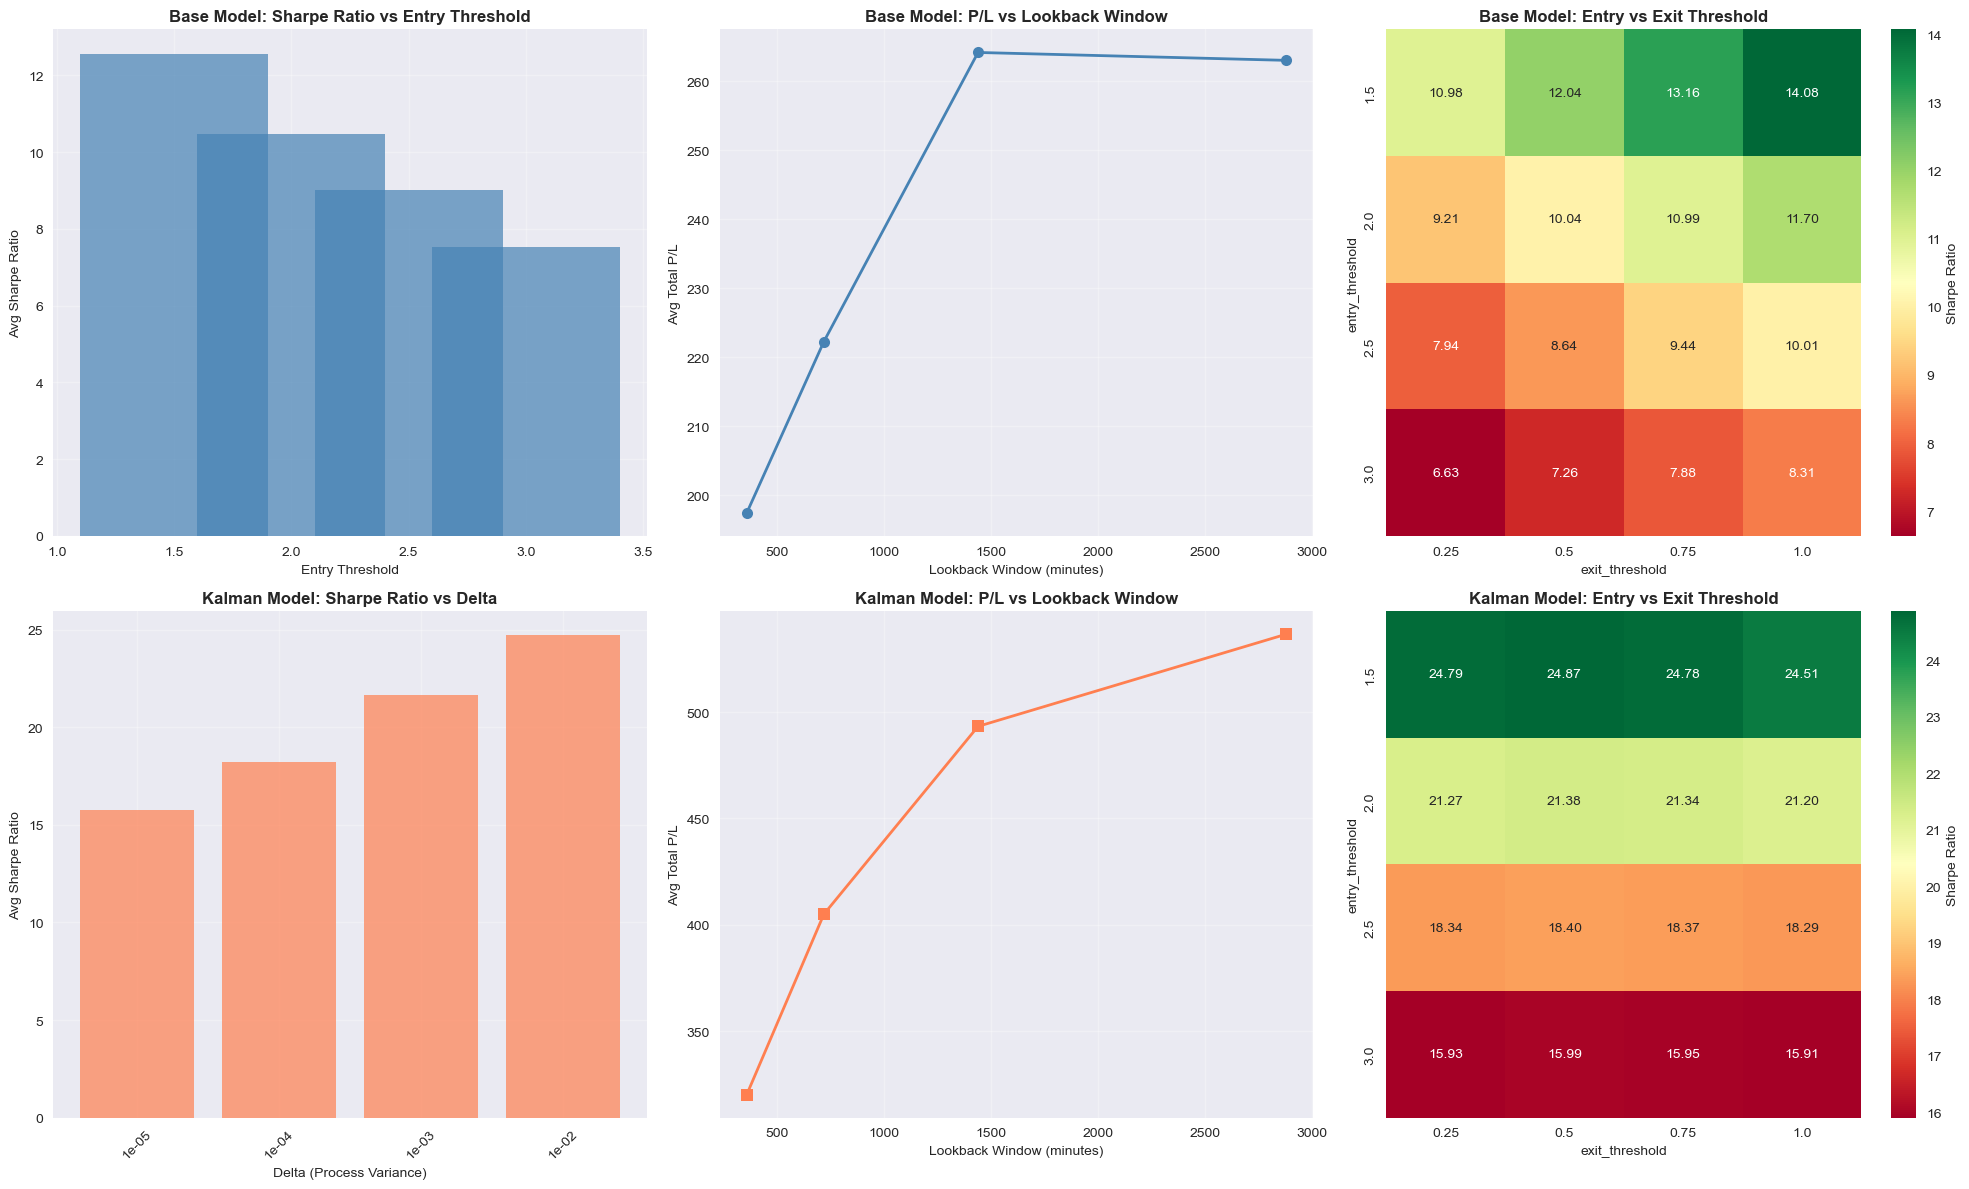


FINAL COMPARISON: OPTIMIZED MODELS

Running Optimized Base Model...
Running Optimized Kalman Model...

PERFORMANCE COMPARISON - OPTIMIZED MODELS
               Base_Model_Optimized  Kalman_Filter_Optimized
Total_PnL                362.373742               622.029156
Sharpe_Ratio              15.763732                31.880014
Max_Drawdown              -2.006790                -0.724648
Win_Rate                   0.125299                 0.121544
Avg_Trade_PnL              0.008841                 0.023507
Rank_PnL                   2.000000                 1.000000
Rank_Sharpe                2.000000                 1.000000
Rank_Drawdown              2.000000                 1.000000

IMPROVEMENT ANALYSIS

Kalman vs Base Model:
  P/L Improvement: +71.65%
  Sharpe Improvement: +102.24%
  Drawdown Improvement: +63.89%


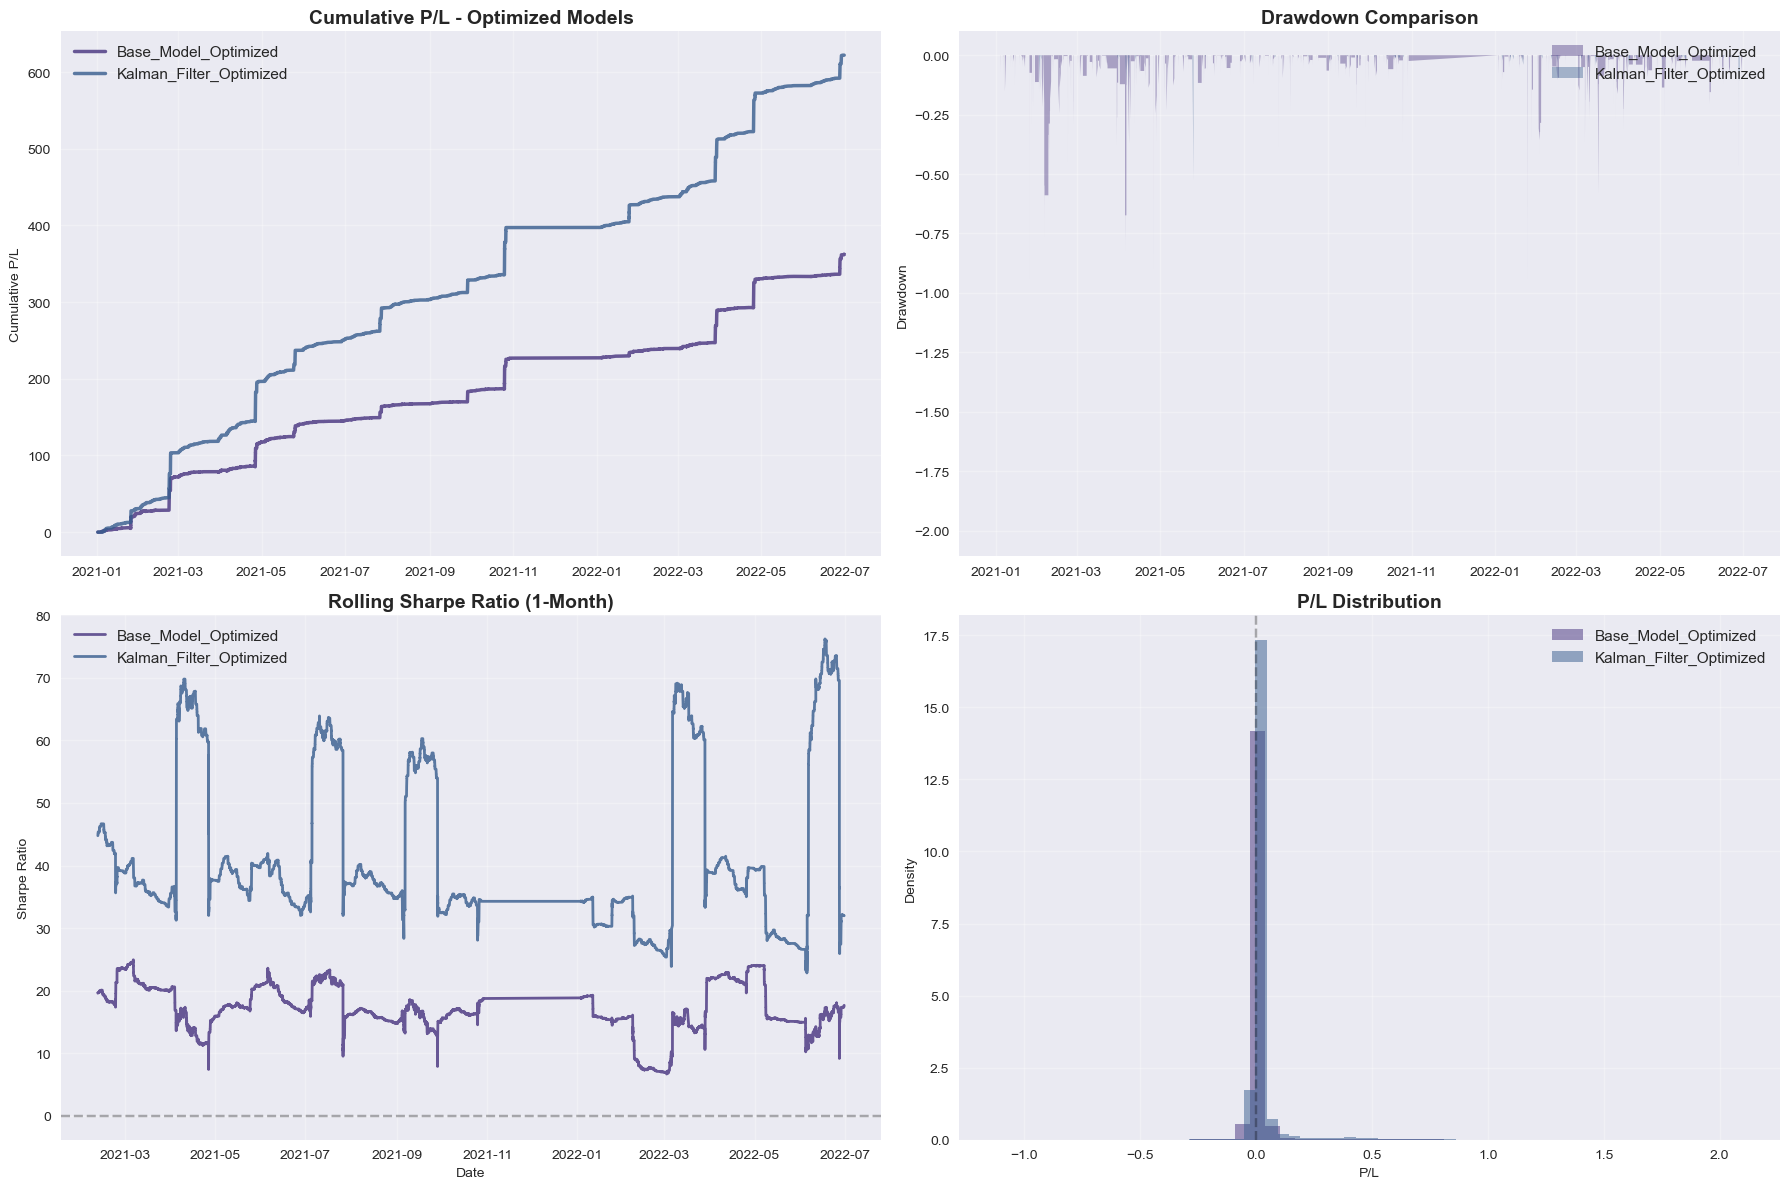

In [94]:
def main_with_optimization(df_imputed, optimization_metric='Sharpe_Ratio'):
    """
    Main function to run complete grid search and optimization.
    
    Parameters:
    - df_imputed: Preprocessed dataframe
    - optimization_metric: 'Total_PnL', 'Sharpe_Ratio', or 'Max_Drawdown'
    """
    
    print("="*50)
    print("GRID SEARCH PARAMETER OPTIMIZATION")
    print("="*50)
    
    # Step 1: Create parameter grids
    base_param_grid, kalman_param_grid = create_parameter_grids()
    
    # Step 2: Grid search for base model
    base_best_params, base_results = grid_search_base_model(
        df_imputed, 
        base_param_grid, 
        optimization_metric
    )
    
    # Step 3: Grid search for Kalman model
    kalman_best_params, kalman_results = grid_search_kalman_model(
        df_imputed, 
        kalman_param_grid, 
        optimization_metric
    )
    
    # Step 4: Visualize grid search results
    print(f"\n{'='*50}")
    print("Generating Grid Search Visualizations...")
    print(f"{'='*50}")
    plot_grid_search_results(base_results, kalman_results)
    
    # Step 5: Compare optimized models
    strategies, comparison = compare_optimized_models(
        df_imputed, 
        base_best_params, 
        kalman_best_params
    )
    
    return strategies, comparison, base_results, kalman_results

if __name__ == "__main__":
    # Run optimization (choose metric: 'Sharpe_Ratio', 'Total_PnL', or 'Max_Drawdown')
    strategies, comparison, base_results, kalman_results = main_with_optimization(
        df_imputed, 
        optimization_metric='Sharpe_Ratio'
    )

### Summary of Results & Findings

#### 1. Performance Overview
The backtesting results present two strategies that appear to generate exceptional risk-adjusted returns with the same parameter set/control:

* **Base Model (Static Z-Score):** Sharpe Ratio of **10.14**, Total P/L of **274.25**.
* **Kalman Filter (Dynamic Beta):** Sharpe Ratio of **20.92**, Total P/L of **558.88**.

While the Kalman Filter strategy significantly outperformed the Base Model by dynamically adjusting the hedge ratio ($\beta$) to the changing correlation between Bank Nifty and Nifty, **extreme caution is required in interpreting these figures.**

#### 2. Critical Analysis of Anomalies
A visual inspection of the **Cumulative P/L** curve reveals a "Step Function" profile rather than a natural accumulation of returns. The P/L remains relatively flat for periods and then experiences vertical jumps. This indicates a **Data Stitching Artifact**:

* **The Issue:** The dataset probably consists of stitched options contracts. When one contract expires and the data rolls to the next month, there is often a discrete jump in Implied Volatility (IV) and a reset in Time to Expiry (TTE).
* **The Error:** The P/L calculation `spread.diff()` captures the difference between the old contract's IV and the new contract's IV during the rollover minute. This creates a "phantom profit" that is not tradable in reality.
* **Conclusion:** The reported P/L is significantly overstated due to these rollover jumps. A robust production model must mask P/L calculations during contract transition periods.

#### 3. Model Biases & Limitations

##### A. Look-Ahead Bias in Kalman Filter
The Kalman Filter strategy shows a Sharpe Ratio nearly double that of the Base Model. However, this implementation likely suffers from **Look-Ahead Bias**:
* The current algorithm updates the state estimate (Beta) using the observation at time $t$, and then calculates the trading signal (Spread) for the *same* time $t$.
* In a live trading environment, we must calculate the signal using the *predicted* Beta (based on information up to $t-1$) before observing the price at $t$. The current results effectively "peek" at the current price to optimize the hedge ratio, artificially collapsing the spread variance.

##### B. Absence of Transaction Costs
The strategy executes a high volume of trades (**6,771 trades** for the Kalman model). The current P/L calculation assumes:
* Zero slippage.
* Zero brokerage/transaction fees.
* Infinite liquidity at the mid-price.
Given the mean-reverting nature of the strategy, even a modest transaction cost (e.g., 2-3 bps) could significantly erode the Sharpe Ratio, potentially rendering the high-frequency Kalman strategy unprofitable.

#### 4. Proposed Improvements for Production

To transition this research into a deployable strategy, the following changes are recommended:

1.  **Rollover Masking:** Implement logic to detect positive jumps in `Time to Expiry` (TTE) and force P/L to zero for those specific timestamps to remove stitching artifacts.
2.  **Strict Walk-Forward Validation:** Modify the Kalman Filter to separate the *Predict* and *Update* steps distinctively to ensure signals are generated using only prior data.
3.  **Transaction Cost Modeling:** Incorporate a cost function (e.g., `positions.diff().abs() * cost_per_trade`) to penalize excessive trading.
4.  **Stationarity Testing:** While Z-Scores assume stationarity, IV spreads can exhibit structural breaks. Implementing an **Augmented Dickey-Fuller (ADF) test** or a Hurst Exponent filter could help filter out non-mean-reverting regimes.
5.  **Stop-Loss Mechanisms:** The current model relies purely on mean reversion. Adding a "hard stop" (e.g., if Z-score expands beyond 4.0) would protect against regime shifts where the correlation permanently breaks.